# Car price prediction

This project was created during an ML course I took. 
It Allowed me to push myself even further during the course and achieve even better results. 
This problem was previously solved during a Kaggle competition, so I also had opportunity to compare my score with others.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from collections import Counter

import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Using TensorFlow backend.


Importing data:

Each entry in this database is a car with 155 features including car_price -> target variable

There are two subsets of data: train and test (test set is missing target variable), but for now they will be merged together.

In [2]:
train = pd.read_hdf('../car.h5')
test = pd.read_hdf('../test.car_price.h5')
print(train.shape)
print(test.shape)
train.sample()

(106494, 155)
(54122, 153)


,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,...,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
2473,"[Osobowe, Mazda, 3, Mazda 3 I (2003-2009)]","19:29, 4 marca 2018",PLN,"Cena Brutto, Do negocjacji",12700.0,"Ostrołęka, Mazowieckie",None,Osoba prywatna,False,False,...,None,Używane,I (2003-2009),None,None,None,Tak,None,None,2473


In [3]:
df = pd.concat([train, test], sort=False)
del train, test
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160616 entries, 0 to 160613
Columns: 155 entries, breadcrumb to car_id
dtypes: bool(70), float64(1), int64(1), object(83)
memory usage: 116.1+ MB


Dataframe is to large for all information to show with default settings, so the settings were changed

In [4]:
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
df.head(3)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False

In [5]:
df.dtypes

breadcrumb                                        object
created_at                                        object
price_currency                                    object
price_details                                     object
price_value                                      float64
seller_address                                    object
seller_name                                       object
seller_type                                       object
feature_czujniki-parkowania-przednie                bool
feature_poduszka-powietrzna-chroniąca-kolana        bool
feature_kurtyny-powietrzne                          bool
feature_klimatyzacja-dwustrefowa                    bool
feature_światła-led                                 bool
feature_czujnik-zmierzchu                           bool
feature_elektrycznie-ustawiane-lusterka             bool
feature_asr-(kontrola-trakcji)                      bool
feature_poduszka-powietrzna-kierowcy                bool
feature_cd                     

After preliminary data analysis there are few main issues to deal with:
- Target variable (car price) is in two currencies
- Some features are stored in two columns at the same time for example: 'param_liczba-drzwi' and 'param_door-count'
- Numerical data is stored as text

So starting with target variable it was normalized into one currency. For now fixed exchange rate was used equal 4.5. In effect a new target variable was created 'price_value_PLN'

In [6]:
df['price_currency'].value_counts()

PLN    160288
EUR       328
Name: price_currency, dtype: int64

In [7]:
def normalize_price_value(x):
    if x['price_currency'] == 'PLN':
        return x['price_value']
    elif x['price_currency'] == 'EUR':
        return x['price_value'] * 4.5
    
df['price_value_PLN'] = df[['price_currency', 'price_value']].apply(normalize_price_value, axis=1)

In [8]:
df.sample(5)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN
64488,"[Osobowe, Volkswagen, Golf, Volkswagen Golf IV...","08:50, 2 marca 2018",PLN,Cena Brutto,4950.0,"Popiełuszki 39 - 45-601 Opole, Opolskie (Polska)",KUBISIAK-CARS,Dealer,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,

Target variable has a 'long tale' distribution so alternative logarithmic target variable 'price_value_PLN_log' was created, which in theory can be easier to predict. Later both target variables will be used to check which one is easier to predict.

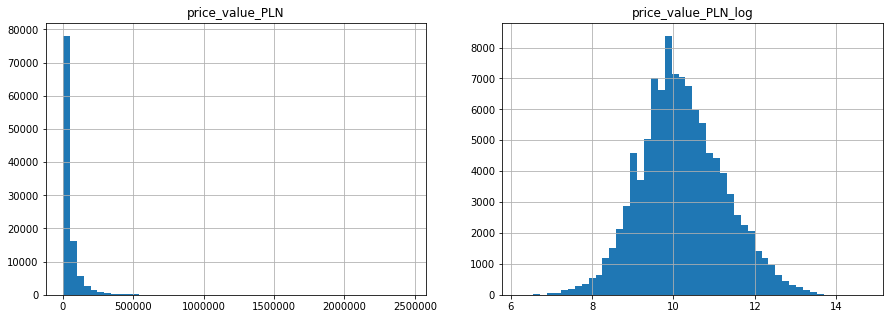

In [9]:
df['price_value_PLN_log'] = np.log1p(df['price_value_PLN'])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['price_value_PLN'].hist(bins=50);
plt.title('price_value_PLN');
plt.subplot(1,2,2)
df['price_value_PLN_log'].hist(bins=50);
plt.title('price_value_PLN_log');

For now to speed up first model development all missing data was replaced with -1. Later in error analysis it will be decided if that simple solution is good enough.

In [10]:
print(df.isnull().sum().sum())
df = df.fillna(-1)
df.isnull().sum().sum()

9013997


0

For reference a dummy model was created.

In [11]:
model = DummyRegressor()
X = df[ 'seller_address' ]
y = df['price_value_PLN']
model.fit(X, y)
y_pred = model.predict(X)
mean_absolute_error(y_pred, y)

33565.50506397786

# feature engineering 

Standard cross_val_score function does not work with logaritmic target variables, so cross validating function below was created.

In [42]:
def get_X_y_and_cros_val(df, model, feats, log=False): # cross validation with option to use logarithmic target variable
    train_df = df[ df['price_value_PLN'] != -1]
    X = train_df[ feats ].values
    y = train_df['price_value_PLN'].values if not log else train_df['price_value_PLN_log'].values
    
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(y):
        
        train_model = clone(model)
        train_model.fit(X[train_idx], y[train_idx])
        y_pred = train_model.predict(X[test_idx])
        
        y_pred = np.expm1(y_pred) if log else y_pred
        y_test = np.expm1(y[test_idx]) if log else y[test_idx]
              
        score = mean_absolute_error(y_test, y_pred)
        
        scores.append(score)
    return np.mean(scores), np.std(scores)

For now all sets of features will be tested on the same model. To allow fast iterations with little down time while the model trains it will be a DecisionTreeRegressor with max_depth=5

In [13]:
model = DecisionTreeRegressor(max_depth=5, random_state=0)

Firs model was trained only on boolean features since these are good to go.

In [14]:
bool_feats = df.select_dtypes([np.bool]).columns
feats = bool_feats

get_X_y_and_cros_val(model, feats, log=False)

(24992.707740422964, 68.28715648360107)

In [44]:
get_X_y_and_cros_val(df, model, feats, log=True)

NameError: name 'df' is not defined

For now model with the logarithmic target variable scored worse, will be double-checked later.

In [16]:
df.select_dtypes([np.object]).sample(3)

,breadcrumb,created_at,price_currency,price_details,seller_address,seller_name,seller_type,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value
104814,"[Osobowe, Mercedes-Benz, Vito, Mercedes-Benz V...","14:20, 5 marca 2018",PLN,-1,"Malawa, rzeszowski, Podkarpackie",-1,Osoba prywatna,9,-1,Mercedes-Benz,-1,-1,5,-1,-1,-1,-1,649 000 km,Tak,2004,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na tylne koła,-1,Minivan,-1,-1,Manualna,-1,-1,-1,-1,Tak,Osoby prywatnej,150 KM,-1,-1,-1,-1,-1,Diesel,-1,-1,-1,-1,-1,-1,-1,Vito,2 200 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Srebrny,-1,-1,Używane,W639 (2003-2014),-1,-1,-1,-1,-1,-1
154097,"[Osobowe, Seat, Leon, Seat Leon I (1999-2005)]","11:33, 4 marca 2018",PLN,"Cena Brutto, Do negocjacji","Oława, oławski, Dolnośląskie",-1,Osoba prywatna,5,-1,Seat,-1,-1,5,-1,-1,-1,-1,147 000 km,-1,2000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Kompakt,Tak,-1,Manualna,-1,-1,-1,-1,-1,Osoby prywatnej,75 KM,-1,Niemcy,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,Leon,1 400 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Niebieski,-1,-1,Używane,I (1999-2005),-1,-1,-1,-1,-1,-1
91549,"[Osobowe, Audi, 100, Audi 100 C4 (1991-1994)]","11:58, 27 lutego 2018",PLN,Cena Brutto,"SIEDLECKA 48 - 21-400 Łuków, łukowski, Lubelsk...",AUTO KOMIS GOLDCAR SAMOCHODY Z GWARANCJĄ VIP,Dealer,5,-1,Audi,-1,-1,5,-1,-1,14 czerwiec 1993,-1,339 000 km,-1,1993,WAUZZZ4A2PN096605,Tak,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,4x4 (stały),-1,Kombi,Tak,Tak,Manualna,-1,-1,-1,-1,-1,Firmy,230 KM,-1,Szwajcaria,-1,-1,Tak,Benzyna,Tak,-1,-1,-1,-1,-1,-1,100,2 225 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Zielony,-1,-1,Używane,C4 (1991-1994),-1,-1,-1,-1,-1,-1


During many iterations of feature engineering least below were created.

In [17]:
# features worth merging (chosen after feature importance check)
doubles = {'param_liczba-drzwi': 'param_door-count',
          'param_przebieg': 'param_mileage',
           'param_pojemność-skokowa': 'param_engine-capacity',
           'param_emisja-co2': 'param_co2-emissions',
           'param_rok-produkcji': 'param_year',
           'param_rodzaj-paliwa': 'param_fuel-type',
           'param_moc': 'param_engine-power',
           'param_marka-pojazdu': 'param_make',
           'param_napęd': 'param_transmission',
           'param_skrzynia-biegów': 'param_gearbox',
           'param_kraj-pochodzenia': 'param_country-of-origin',
           'param_kolor': 'param_color'
          }

# numerical features
num_feats = ['param_liczba-miejsc', 'param_liczba-drzwi', 'param_przebieg', 'param_moc', 'param_pojemność-skokowa', 'param_emisja-co2', 'param_wartość-wykupu', 'param_liczba-pozostałych-rat', 'param_miesięczna-rata', 'param_opłata-początkowa']

# date features
date_feats = ['param_rok-produkcji', 'created_at', 'param_pierwsza-rejestracja', 'param_first-registration']

# blacklist features will not be used
black_list = ['breadcrumb', 'created_at', 'price_details', 'price_currency', 'price_value', 'price_value_PLN', 'price_value_PLN_log']

###### Mearging columns
As mentioned before some features are divided into two columns.

In [18]:
# Function used to find columns carrying the same information
val_to_check = 'Manualna'
for column in df.columns:
    occurrences = (df[column] == val_to_check).sum()
    if occurrences > 0:
        print('occurrences of {} in {}: {}'.format(val_to_check, column, occurrences))

/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


occurrences of Manualna in param_gearbox: 91
occurrences of Manualna in param_skrzynia-biegów: 110590


To make sure no data is lost in the process each pairs of columns were checked if one column has missing data from other or if both have data for the same record.

In [19]:
def check_if_complementing(feat1, feat2):
    has_data = {feat1: 0 , feat2: 0, 'both': 0}
    for i in range(df.shape[0]):
        if df[feat1].iloc[i] != -1 and df[feat2].iloc[i] != -1:
            has_data['both'] += 1         
        elif df[feat1].iloc[i] != -1:
            has_data[feat1] += 1  
        elif df[feat2].iloc[i] != -1:
            has_data[feat2] += 1  
    print(has_data)
    
for feat1, feat2 in doubles.items():
    check_if_complementing(feat1, feat2)
    print()

{'param_liczba-drzwi': 145688, 'param_door-count': 117, 'both': 0}

{'param_przebieg': 159945, 'param_mileage': 127, 'both': 0}

{'param_pojemność-skokowa': 152840, 'param_engine-capacity': 122, 'both': 0}

{'param_emisja-co2': 3114, 'param_co2-emissions': 3, 'both': 0}

{'param_rok-produkcji': 160327, 'param_year': 128, 'both': 0}

{'param_rodzaj-paliwa': 160327, 'param_fuel-type': 128, 'both': 0}

{'param_moc': 146331, 'param_engine-power': 115, 'both': 0}

{'param_marka-pojazdu': 160327, 'param_make': 128, 'both': 0}

{'param_napęd': 135893, 'param_transmission': 110, 'both': 0}

{'param_skrzynia-biegów': 151750, 'param_gearbox': 121, 'both': 0}

{'param_kraj-pochodzenia': 109150, 'param_country-of-origin': 82, 'both': 0}

{'param_kolor': 160327, 'param_color': 128, 'both': 0}



After confirming that no data will be lost the columns were merged.

In [20]:
def merge_data(x):
    if x.iloc[0] == -1 and x.iloc[1] != -1:
        return x.iloc[1]
    else:
        return x.iloc[0]
    
# merge data
for feat1, feat2 in doubles.items():
    df[feat1] = df[[feat1, feat2]].apply(merge_data, axis=1)
    
# delete no longer needed columns
to_delate = doubles.values()
for d in to_delate:
    del df[d]

###### Caterogical features

Categorical features were selected and changed into numerical values using factorize. 

In [21]:
cat_black_list = black_list + num_feats + date_feats

cat_feats = df.select_dtypes([np.object]).columns
cat_feats = [x for x in cat_feats if x not in cat_black_list]

# using factorize on categorical features
cat_feat_prefix = '__cat'
for cat in cat_feats:
    df[cat + cat_feat_prefix] = pd.factorize( df[cat] )[0]
    
# storing factorized features in 'cat_feats'
cat_feats = df.columns
cat_feats = [x for x in cat_feats if cat_feat_prefix in x]
cat_feats

['seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'param_uszkodzony__cat',
 'param_marka-pojazdu__cat',
 'param_model__cat',
 'param_engine-code__cat',
 'param_faktura-vat__cat',
 'param_vin__cat',
 'param_perłowy__cat',
 'param_homologacja-ciężarowa__cat',
 'param_service-record__cat',
 'param_metallic__cat',
 'param_leasing-concession__cat',
 'param_financing-option__cat',
 'param_original-owner__cat',
 'param_vat-marża__cat',
 'param_kategoria__cat',
 'param_leasing__cat',
 'param_zarejestrowany-jako-zabytek__cat',
 'param_napęd__cat',
 'param_typ__cat',
 'param_metalik__cat',
 'param_pierwszy-właściciel__cat',
 'param_skrzynia-biegów__cat',
 'param_vat-discount__cat',
 'param_no-accident__cat',
 'param_particle-filter__cat',
 'param_zarejestrowany-w-polsce__cat',
 'param_oferta-od__cat',
 'param_kraj-pochodzenia__cat',
 'param_serwisowany-w-aso__cat',
 'param_rodzaj-paliwa__cat',
 'param_możliwość-finansowania__cat',
 'param_registered-in-poland__cat',
 'param_kod-

To check the progress made a model was trained using boolean and cat features. Score improved by more than 5k.

In [22]:
feats = list(bool_feats) + list(cat_feats)
get_X_y_and_cros_val(model, feats, log=False)

(20288.95139293322, 69.39725491228151)

In [23]:
get_X_y_and_cros_val(model, feats, log=True)

(19537.48672661894, 49.22303020283056)

All relevant categorical features were ploted for further analizys (charts are sorted by value_counts)

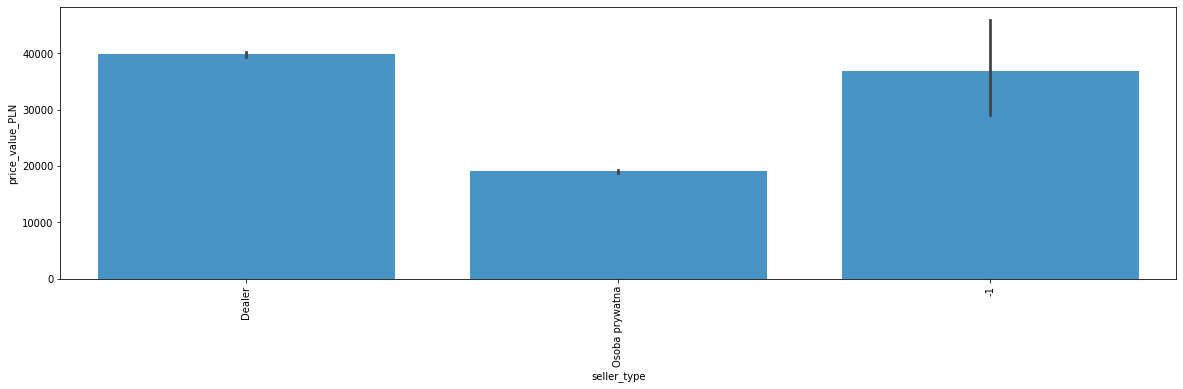

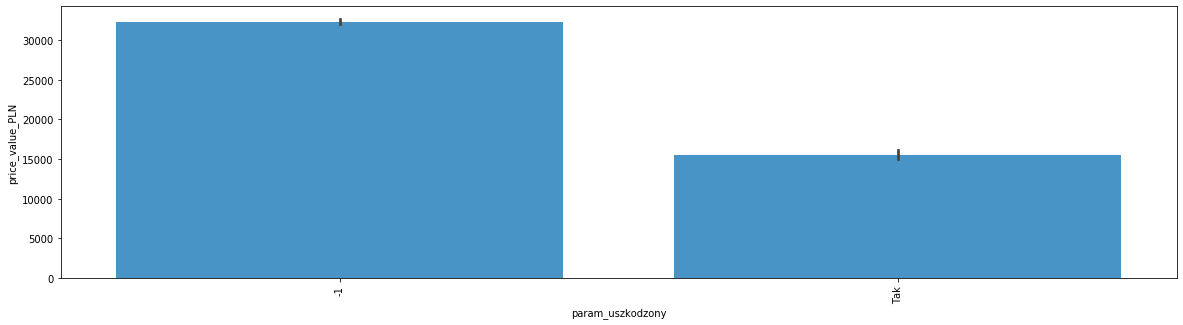

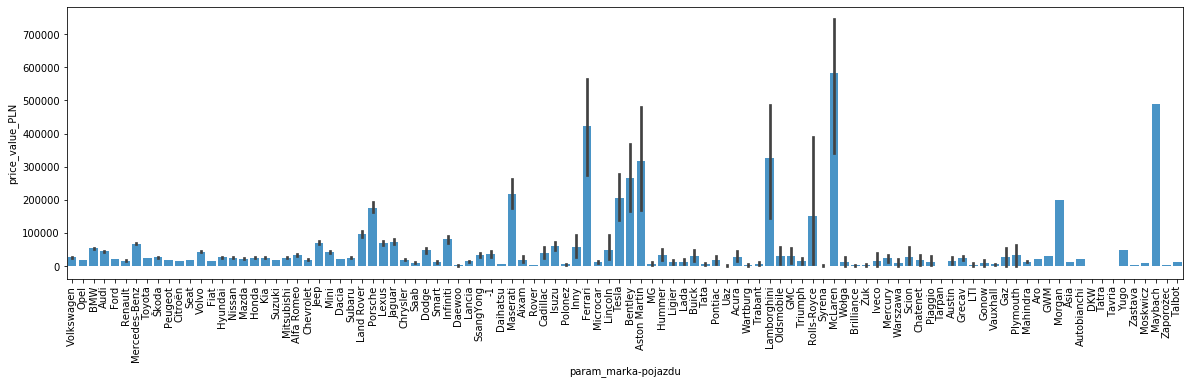

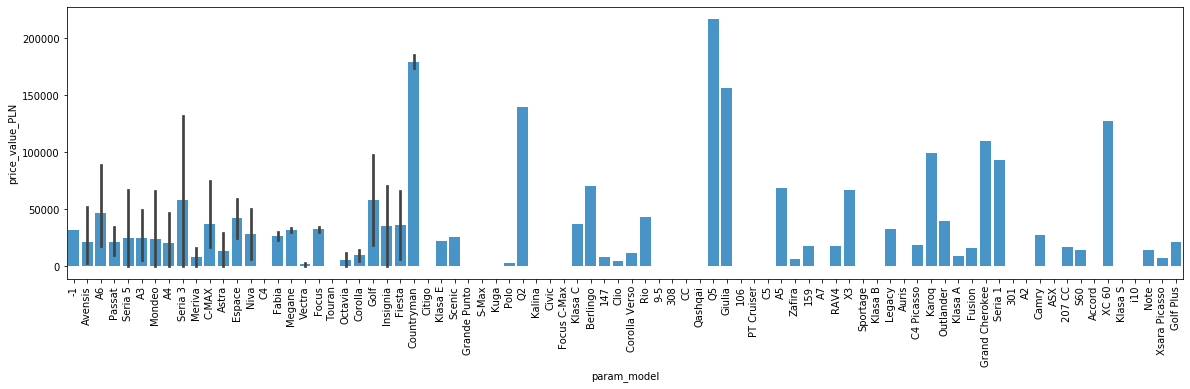

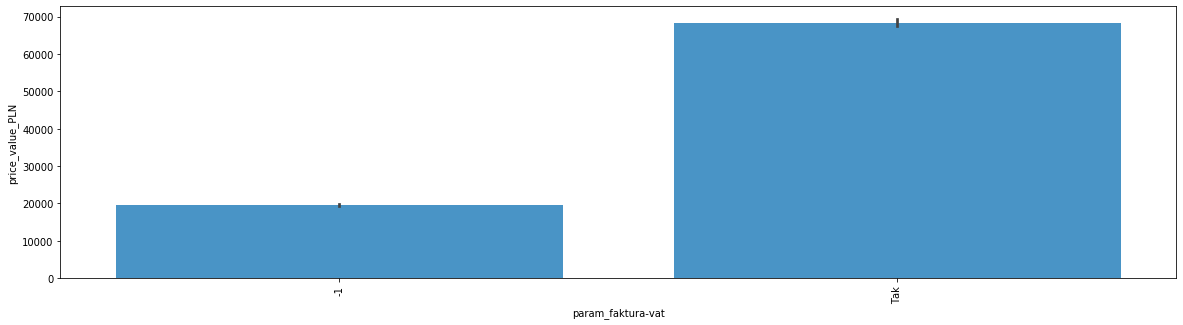

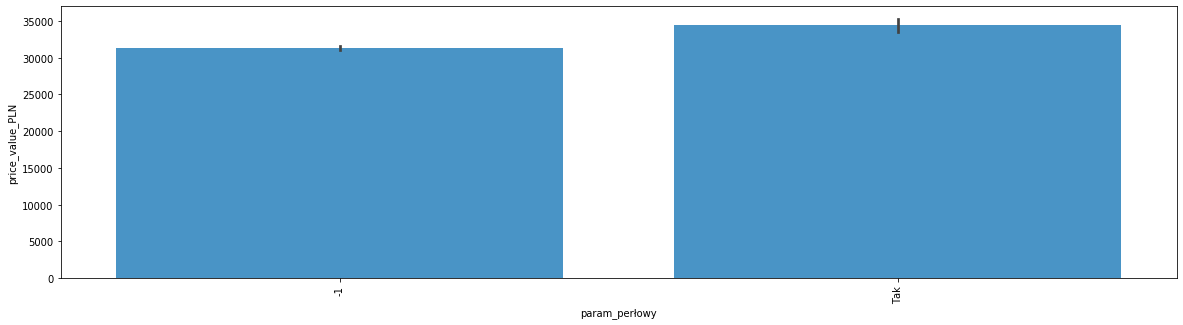

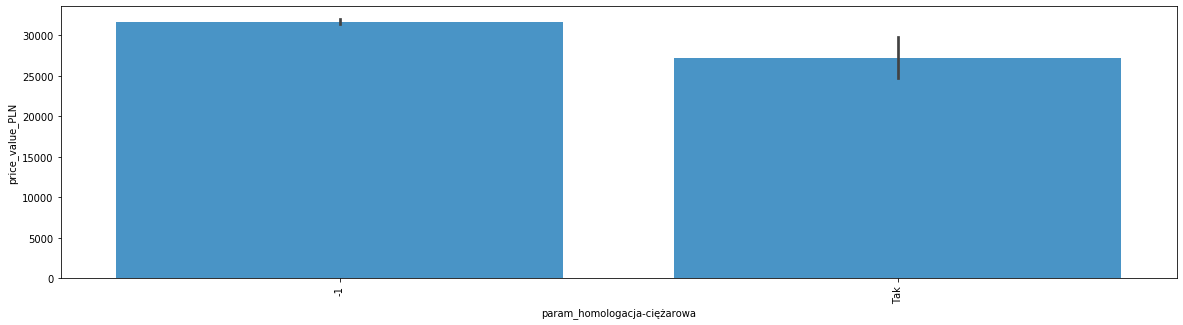

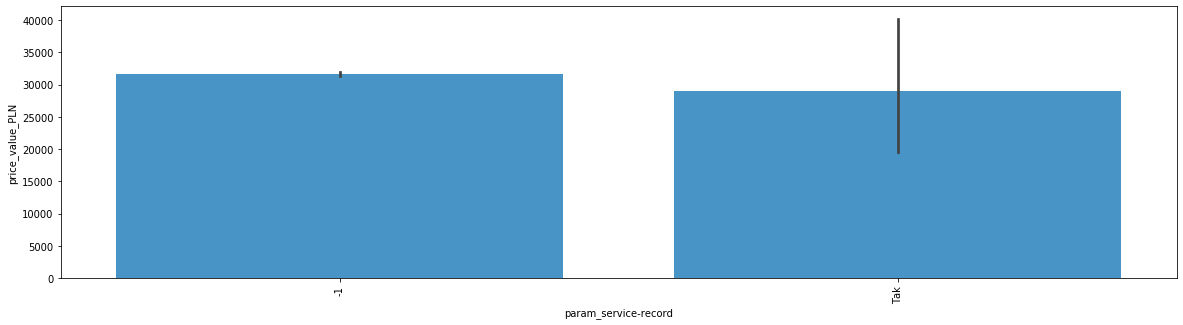

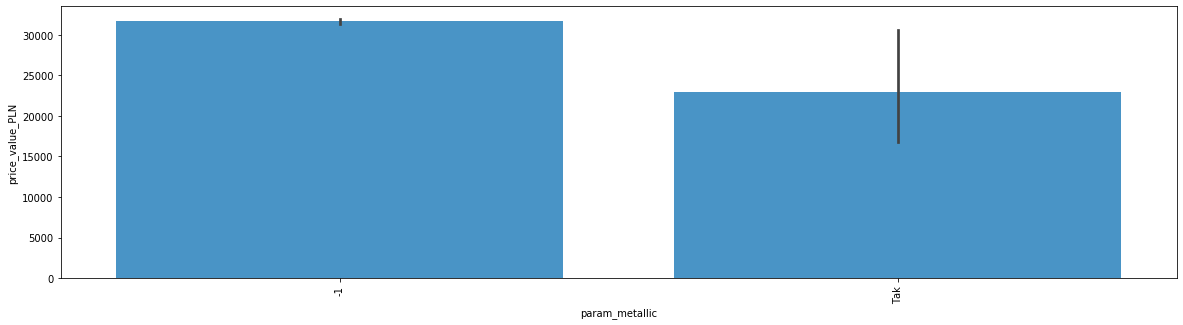

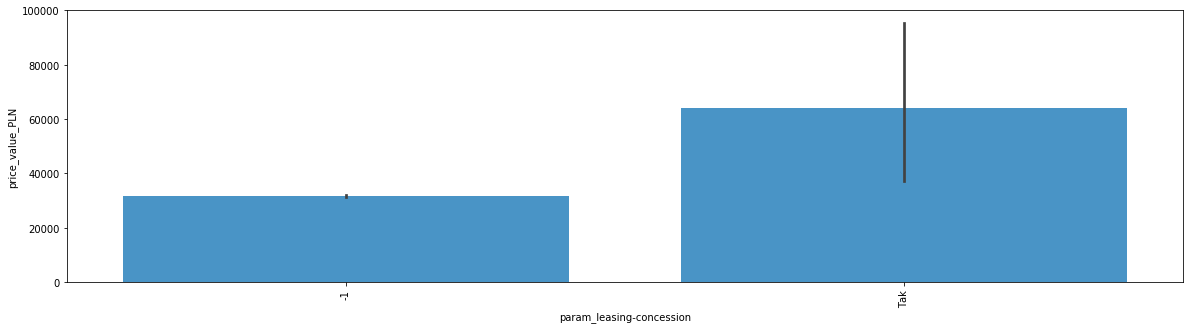

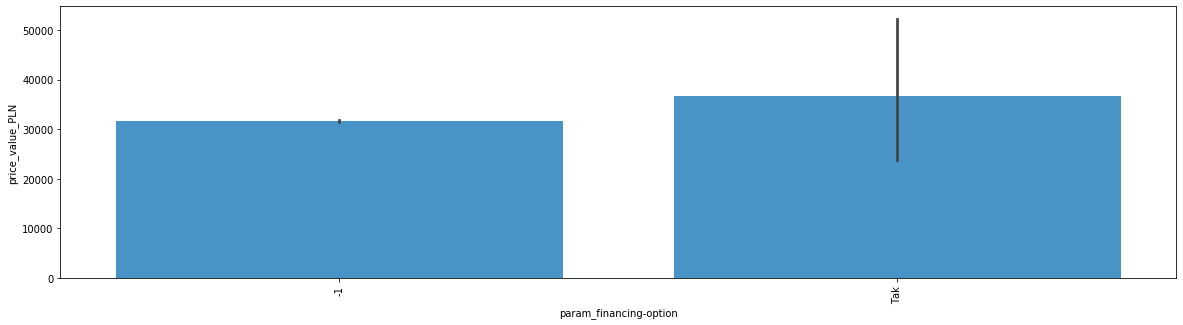

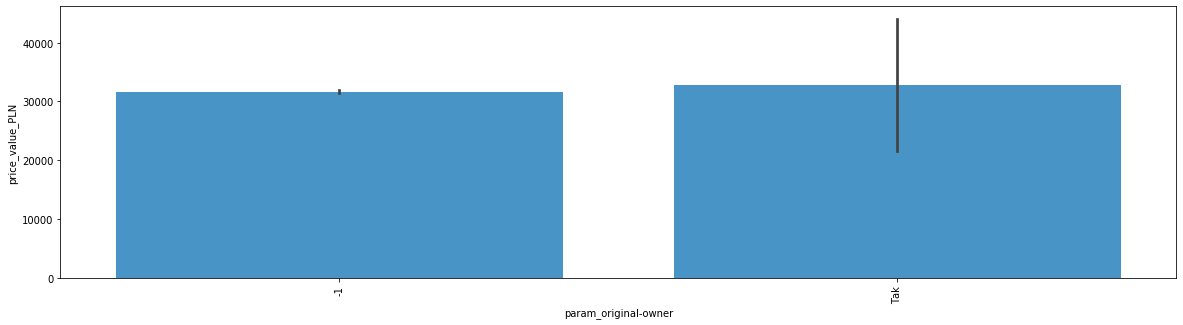

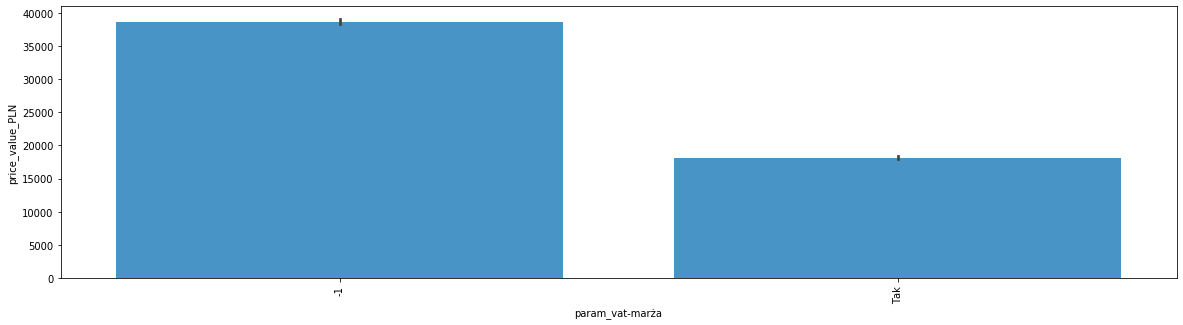

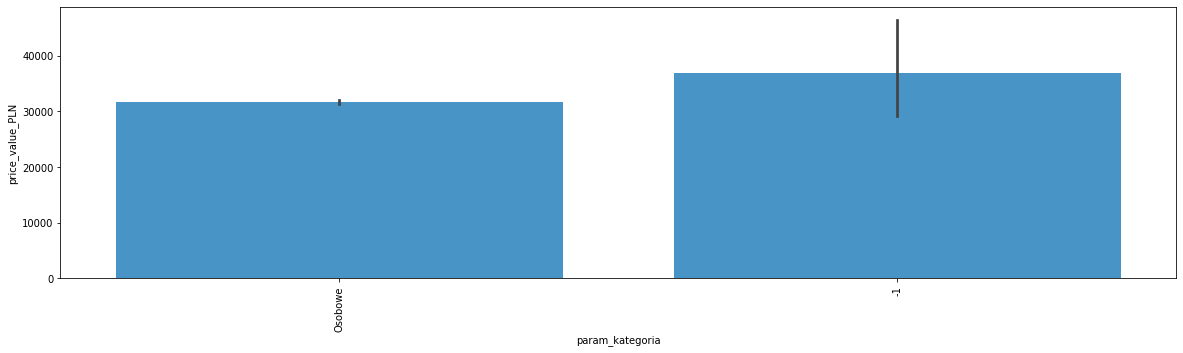

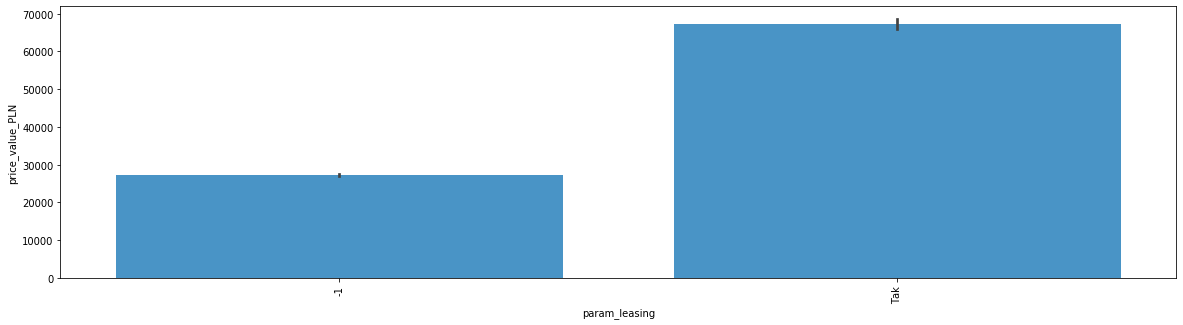

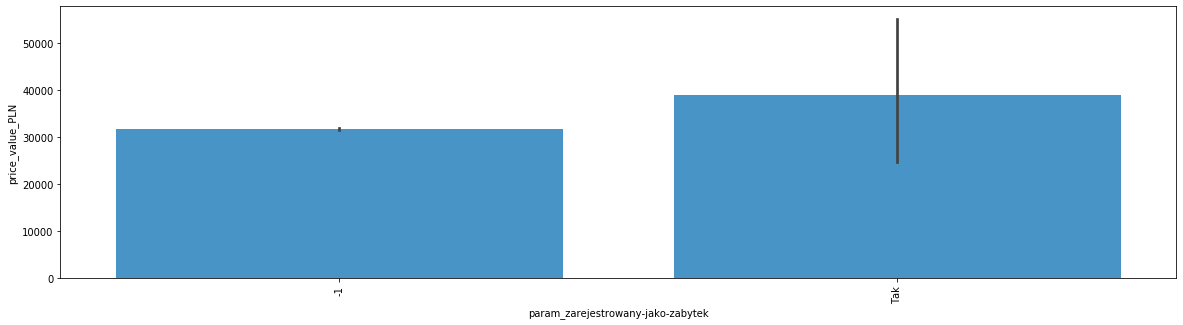

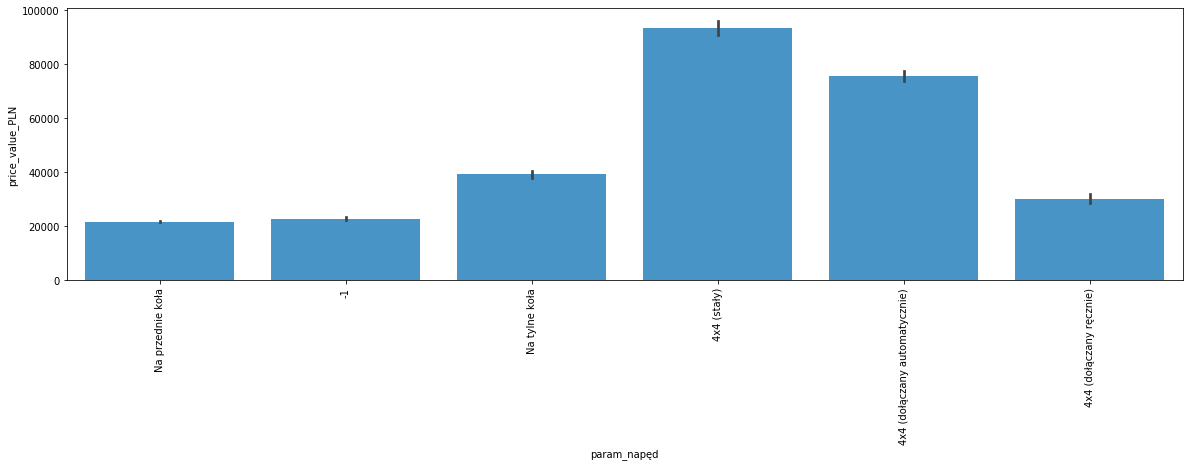

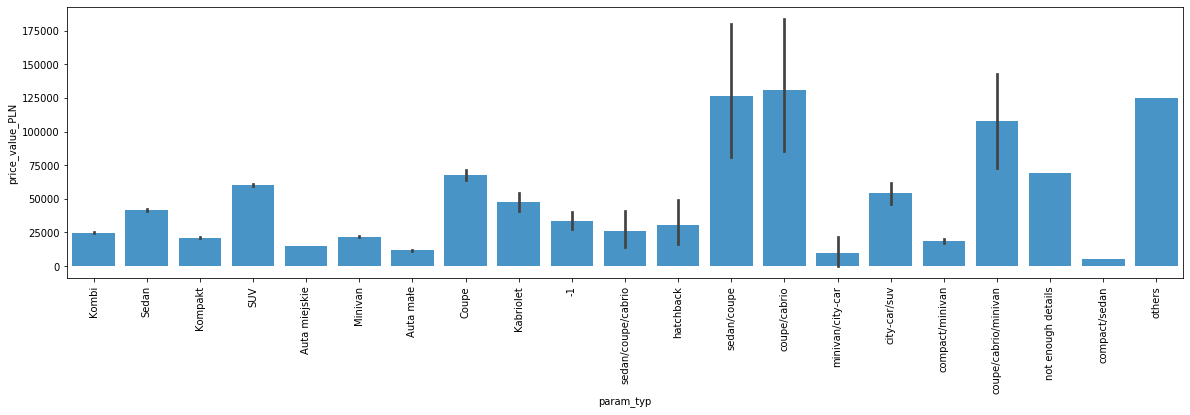

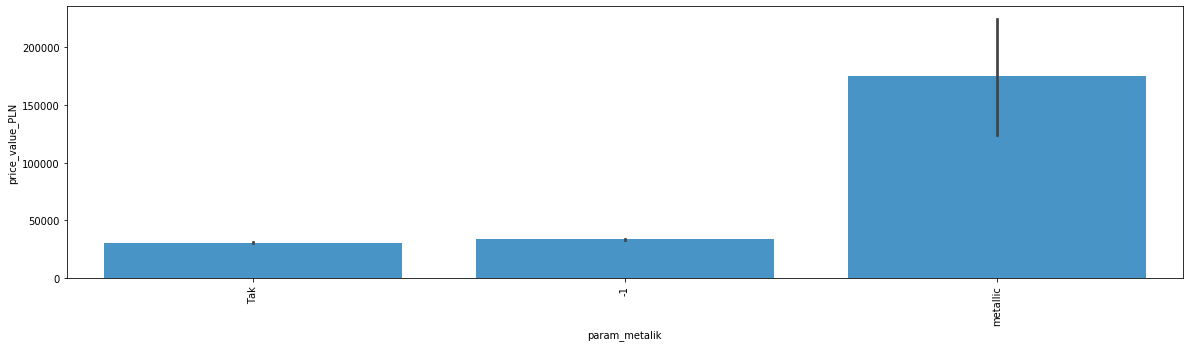

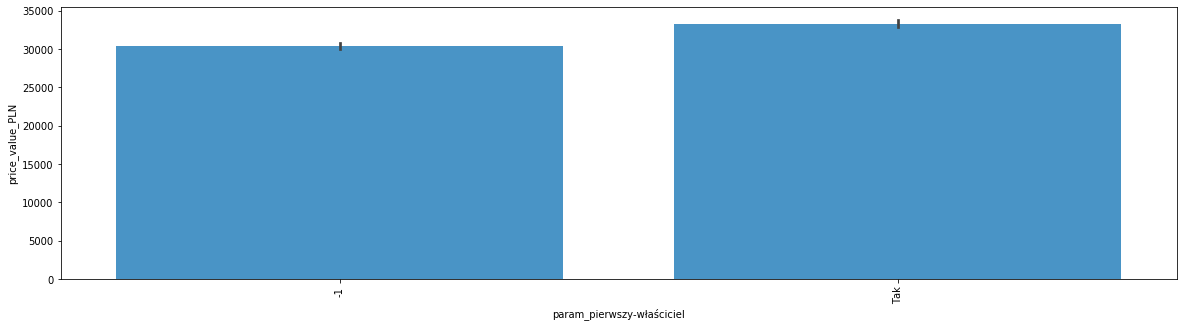

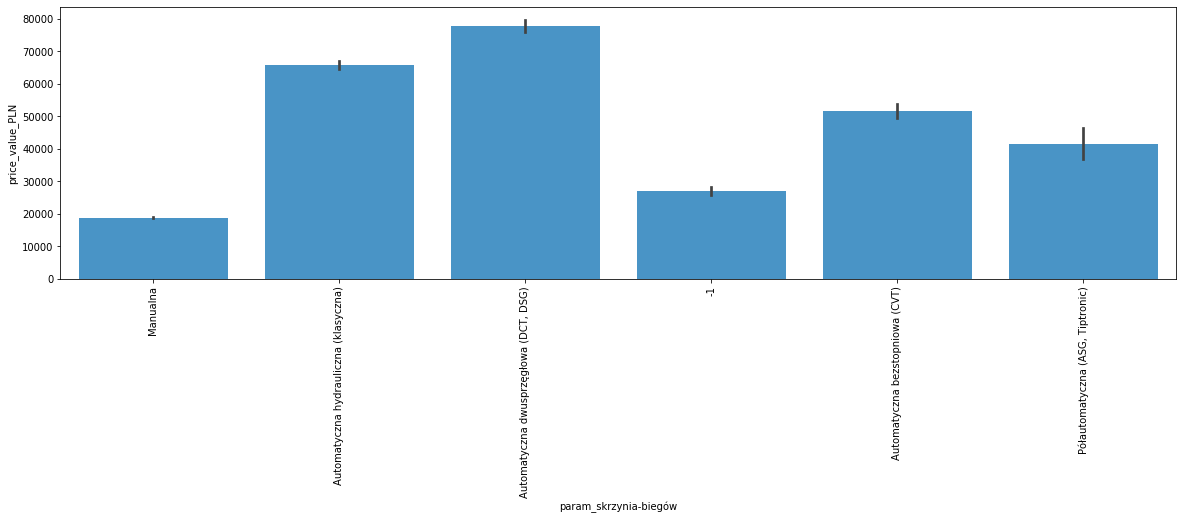

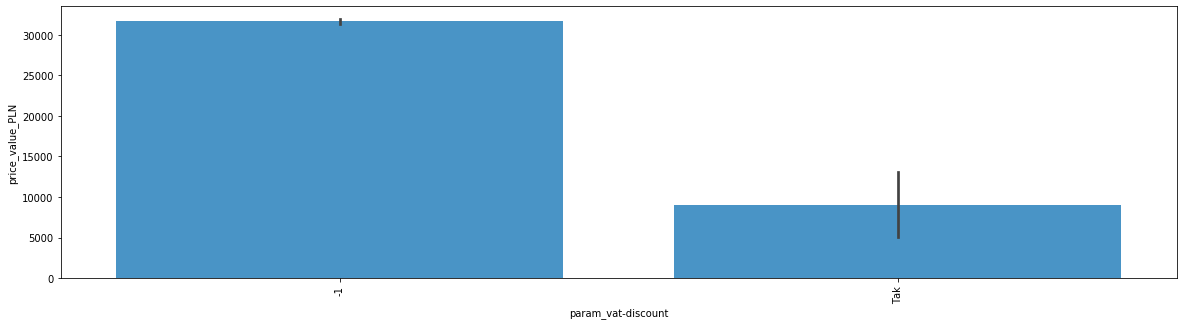

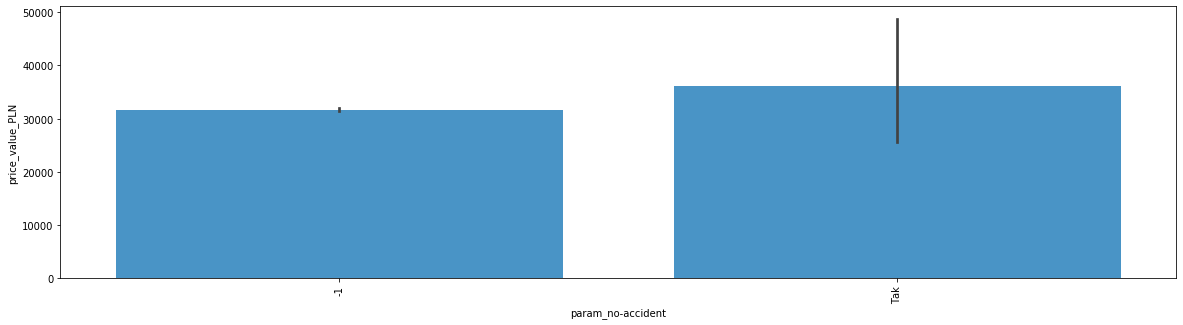

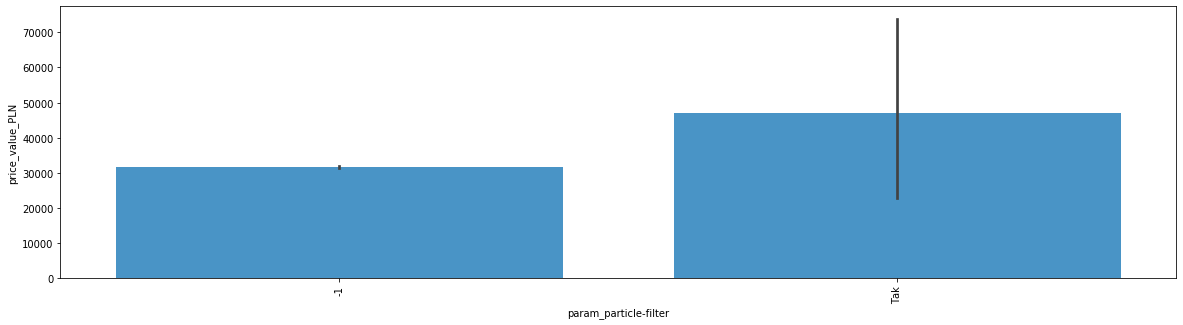

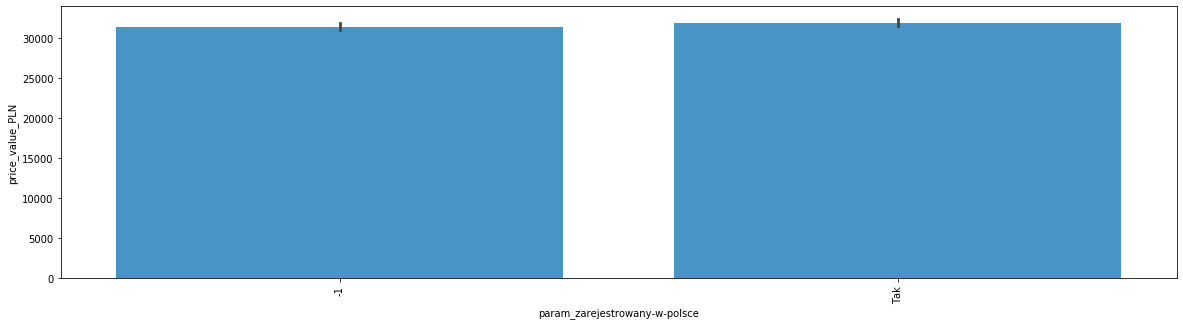

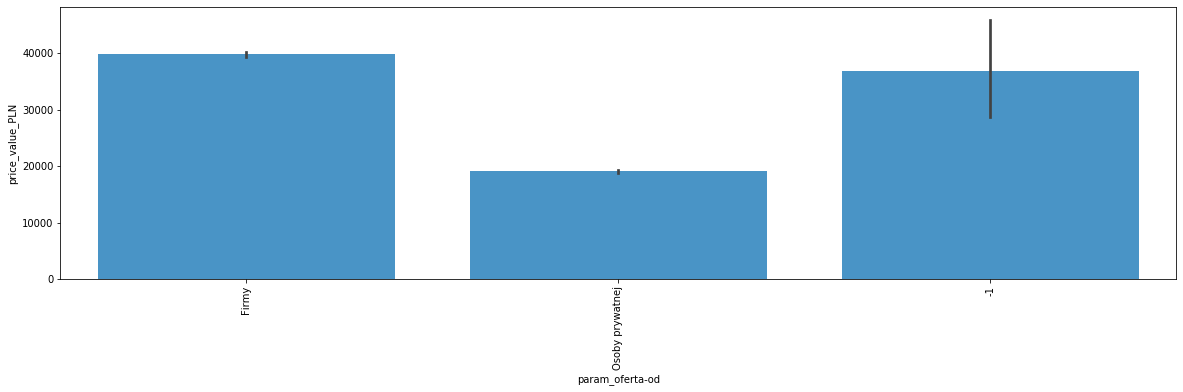

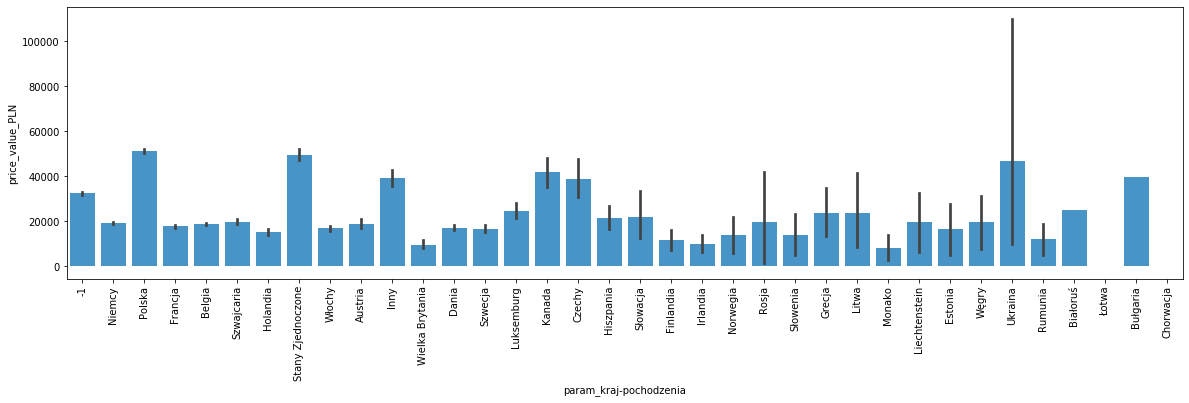

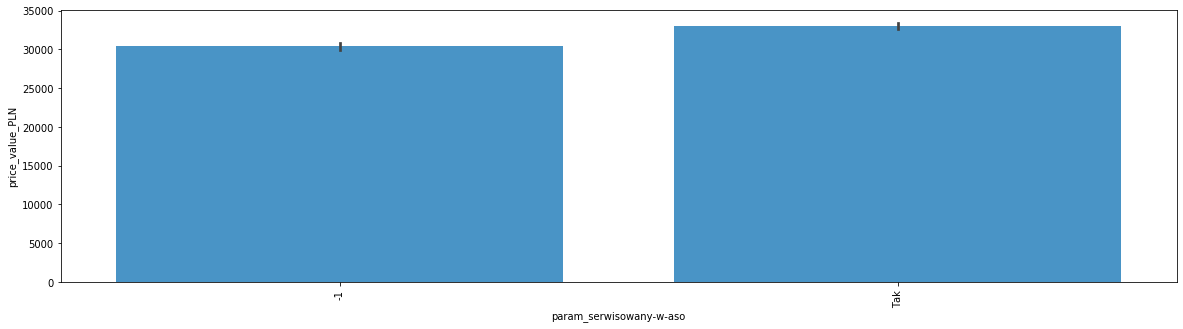

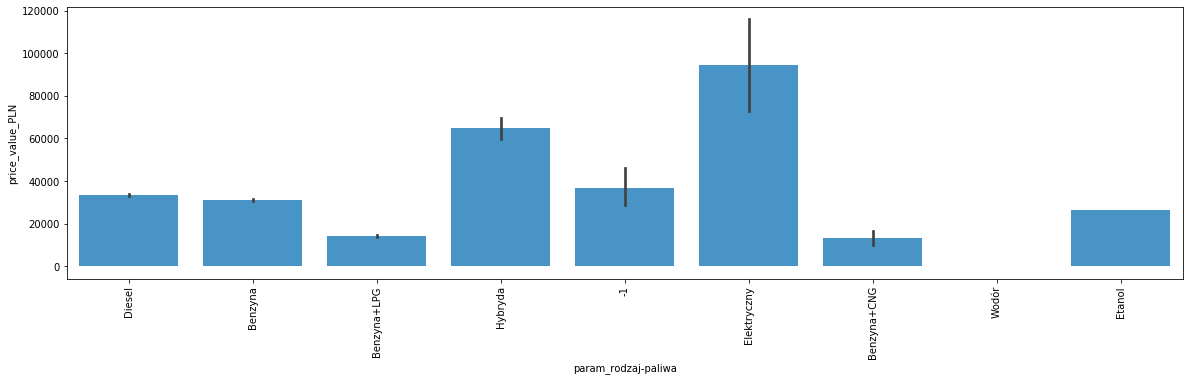

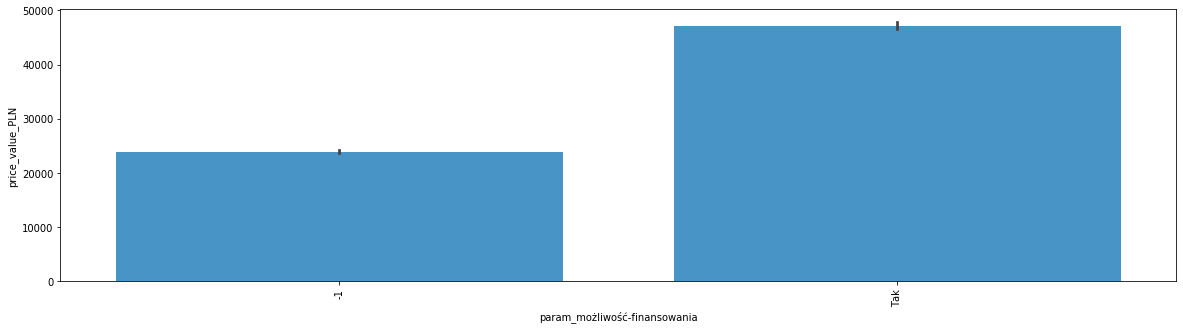

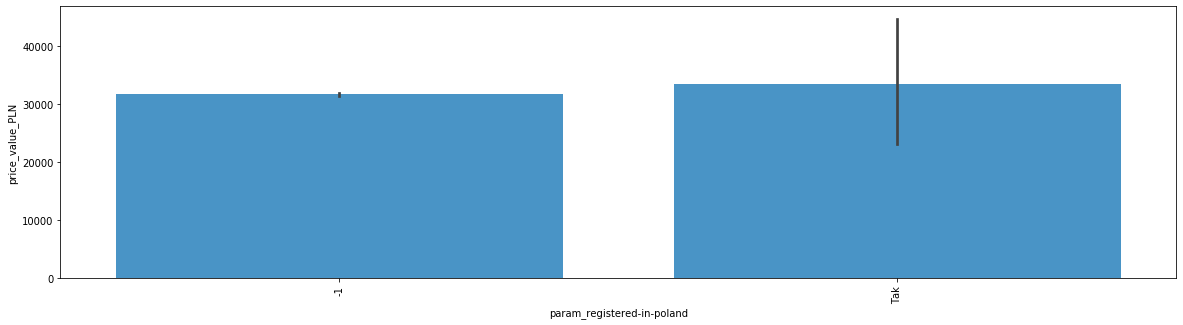

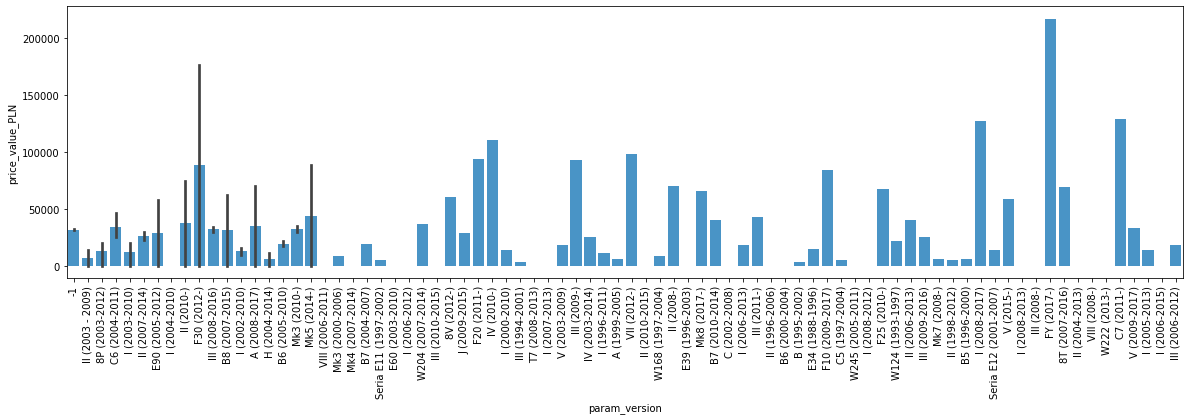

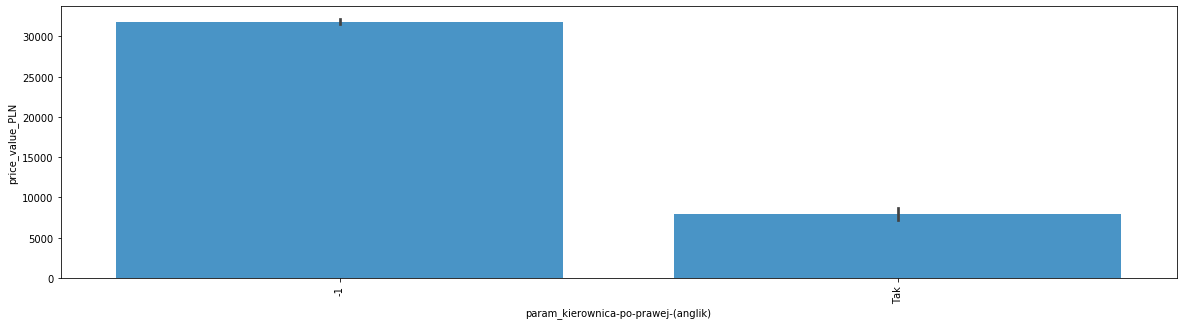

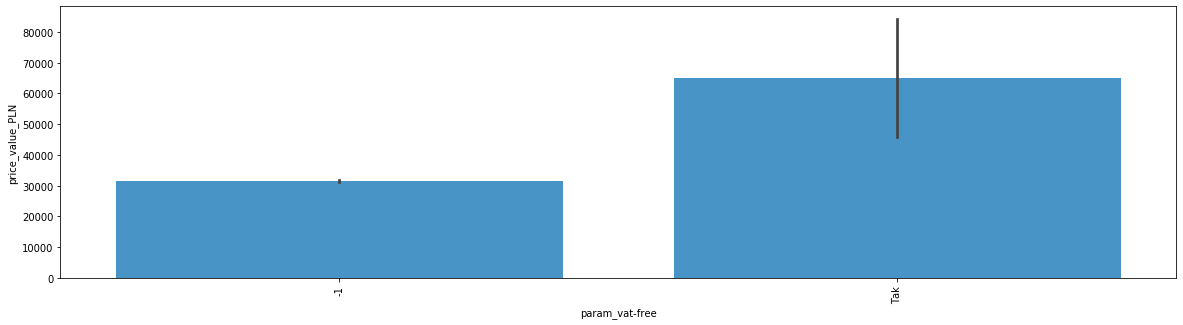

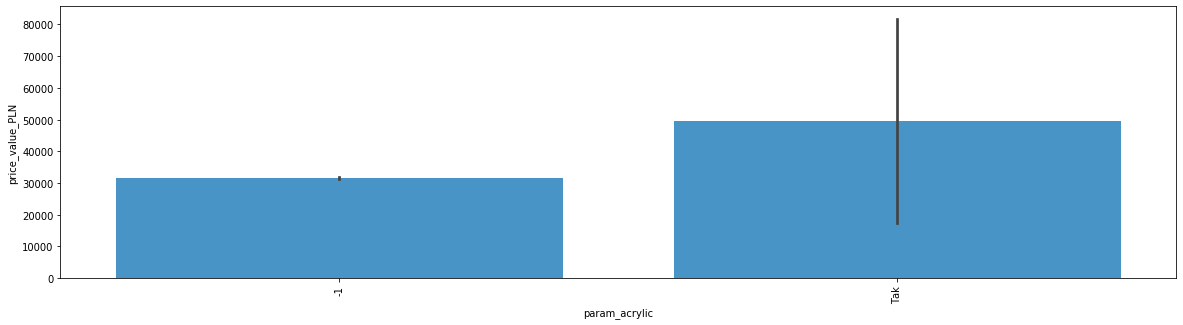

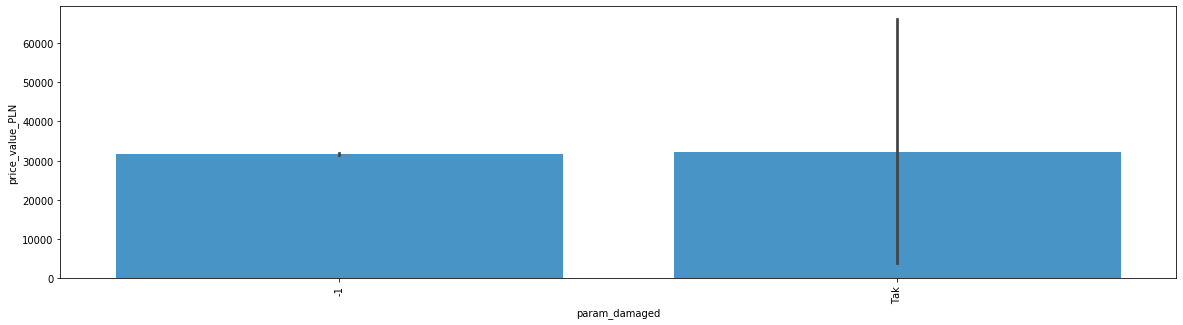

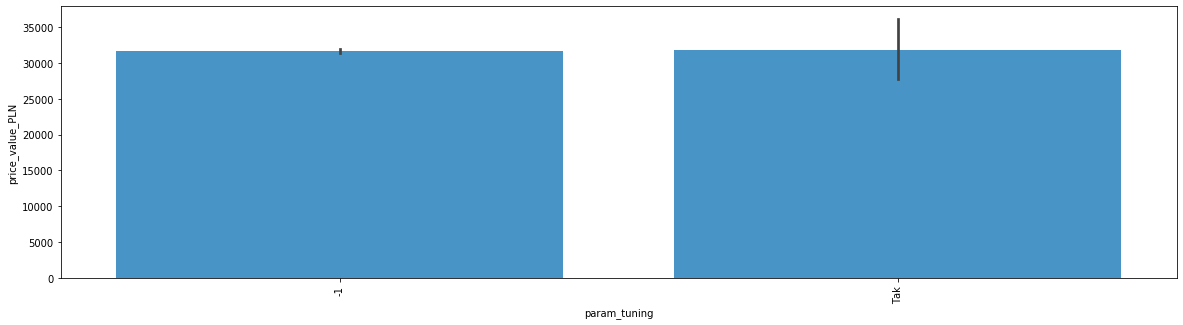

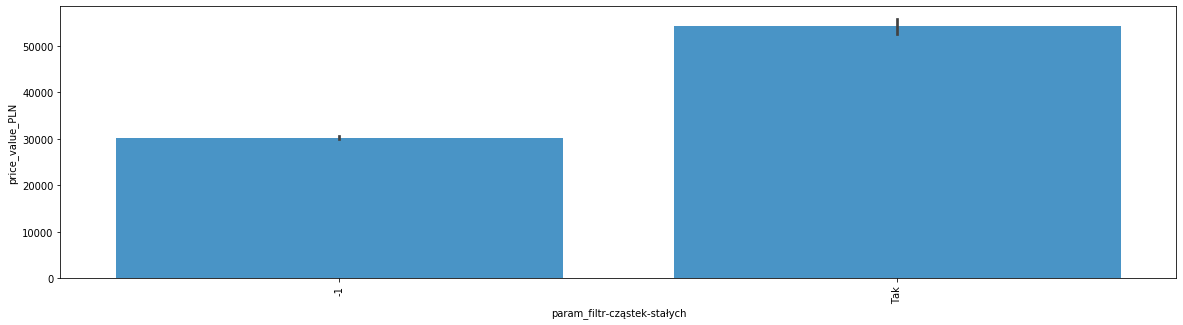

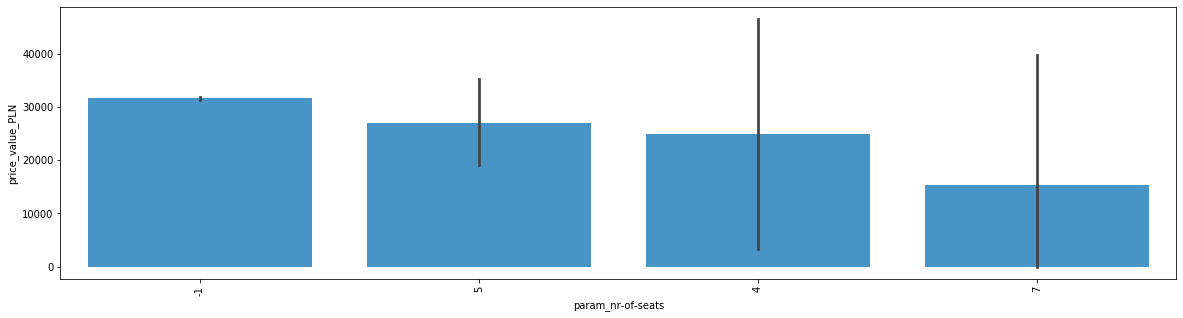

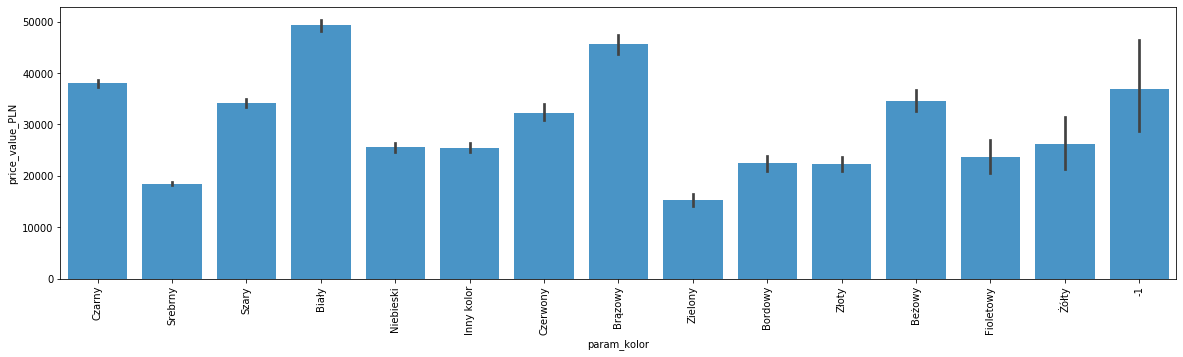

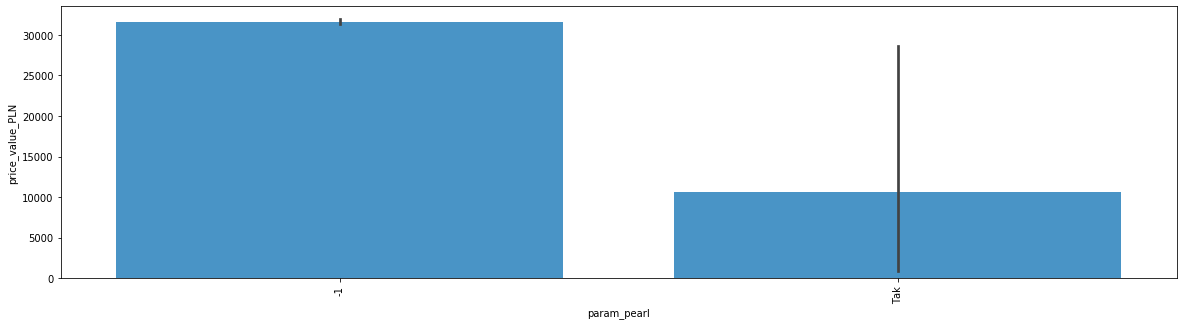

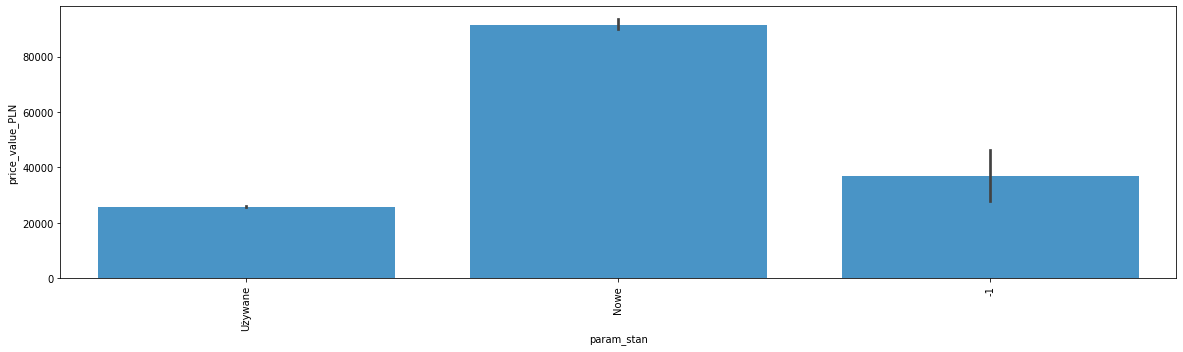

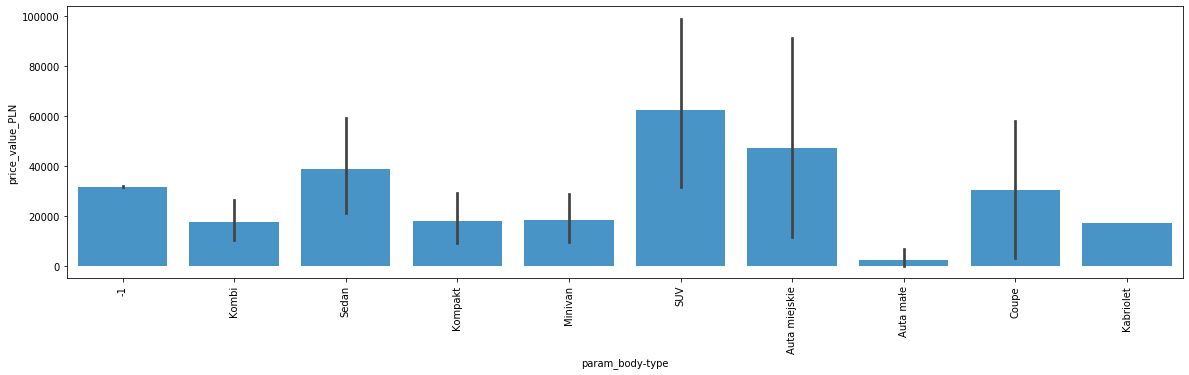

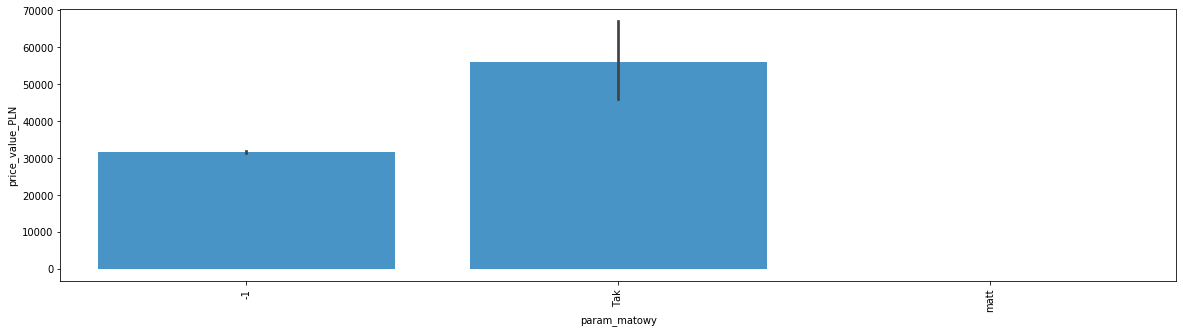

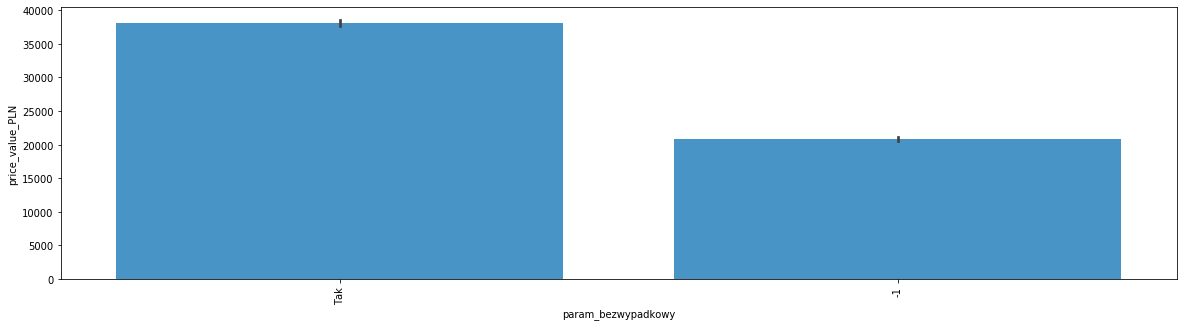

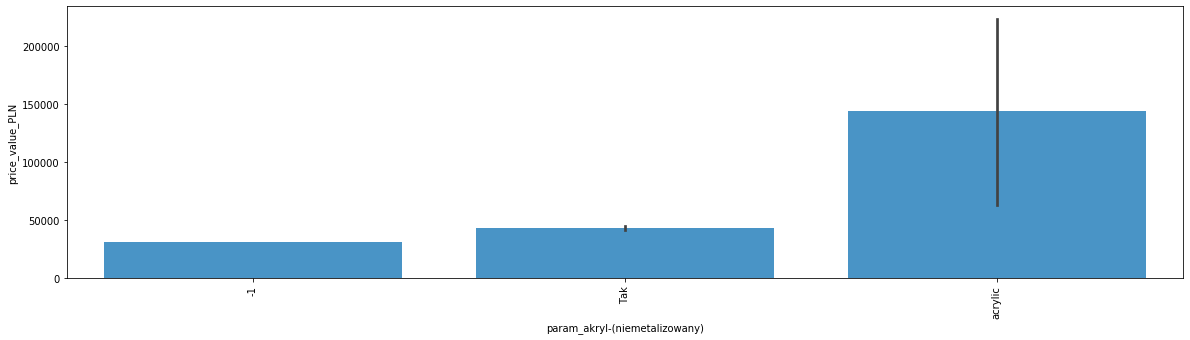

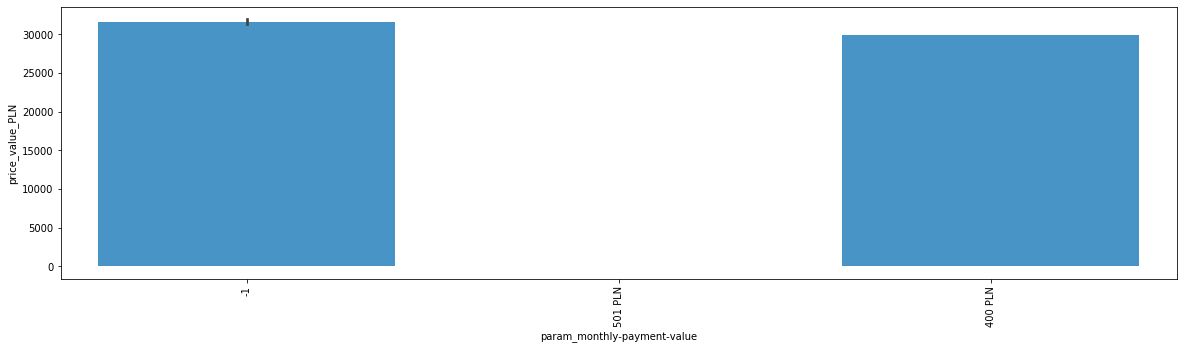

In [24]:
# categories are sorted by value_counts

cat_no_plot = ['price_currency__cat', 'seller_address__cat', 'seller_name__cat', 'param_engine-code__cat','param_vin__cat', 'param_kod-silnika__cat', 'param_wersja__cat', 'param_model-pojazdu__cat']

for cat_feat in cat_feats:
    if cat_feat not in cat_no_plot:
        cat_name = cat_feat[:-len(cat_feat_prefix)]
        plt.figure(figsize=(20,5))
        sns.barplot(x=cat_name, y='price_value_PLN', data=df, order=df[cat_name].value_counts().index, color='#3498db');
        plt.xticks(rotation=90);
        plt.show()

###### numerical features

Numerical features had to be picked manually because they were originally stored as an object. They were stripped of units and spaces, so they can be stored and analized properly from now on.

In [25]:
num_feats

['param_liczba-miejsc',
 'param_liczba-drzwi',
 'param_przebieg',
 'param_moc',
 'param_pojemność-skokowa',
 'param_emisja-co2',
 'param_wartość-wykupu',
 'param_liczba-pozostałych-rat',
 'param_miesięczna-rata',
 'param_opłata-początkowa']

In [26]:
df['param_moc'].sample(5)

127585    110 KM
69664         -1
151986        -1
34053     150 KM
95837         -1
Name: param_moc, dtype: object

In [27]:
def get_rid_of_unit_and_dec(val): # getting rid of units, spaces between numbers and decimals
    if val == -1:
        return -1

    st = ''.join(val.split(' ')[:-1])
    
    if ',' in st:
        st = ''.join(st.split(',')[:-1])

    val = int(st)
        
    return val


num_feat_prefix = '__num'
df['param_liczba-miejsc' + num_feat_prefix] = df['param_liczba-miejsc'].astype(np.int8)
df['param_liczba-drzwi' + num_feat_prefix] = df['param_liczba-drzwi'].astype(np.int8)

df['param_przebieg' + num_feat_prefix] = df['param_przebieg'].map(get_rid_of_unit_and_dec)
df['param_moc' + num_feat_prefix] = df['param_moc'].map(get_rid_of_unit_and_dec)
df['param_pojemność-skokowa' + num_feat_prefix] = df['param_pojemność-skokowa'].map(get_rid_of_unit_and_dec)
df['param_emisja-co2' + num_feat_prefix] = df['param_emisja-co2'].map(get_rid_of_unit_and_dec)
df['param_wartość-wykupu' + num_feat_prefix] = df['param_wartość-wykupu'].map(get_rid_of_unit_and_dec)
df['param_miesięczna-rata' + num_feat_prefix] = df['param_miesięczna-rata'].map(get_rid_of_unit_and_dec)
df['param_opłata-początkowa' + num_feat_prefix] = df['param_opłata-początkowa'].map(get_rid_of_unit_and_dec)

# df['param_liczba-pozostałych-rat' + num_feat_prefix] = df['param_liczba-pozostałych-rat'].map(lambda x: int(''.join(x.split(' '))) if x != -1 else -1 )

df['param_rok-produkcji' + num_feat_prefix] = df['param_rok-produkcji'].astype(np.int16)

num_feats = [x for x in df.columns if num_feat_prefix in x]

To check progress made a model was trained using all prepared features. Score significantly improved.

In [28]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)
get_X_y_and_cros_val(model, feats, log=False)

(14509.849100314479, 234.38889941120485)

In [29]:
get_X_y_and_cros_val(model, feats, log=True)

(13997.826253074796, 35.86168756499168)

To double check if logarithmic 'long tale' features would work in this instance, all 'long tale' numerical features were plotted as logarithmic to visualize if there is an improvement in feature symmetry.

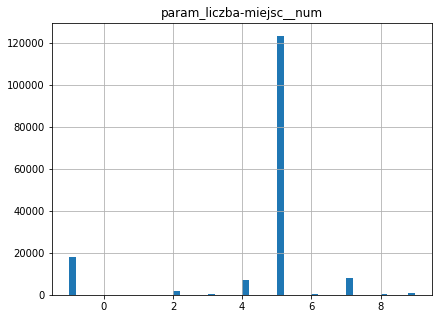

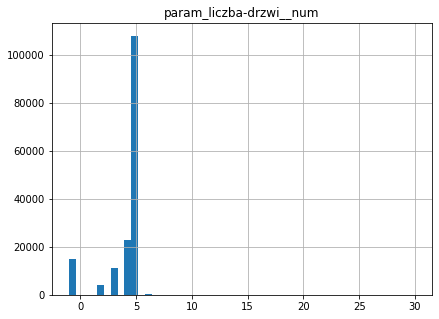

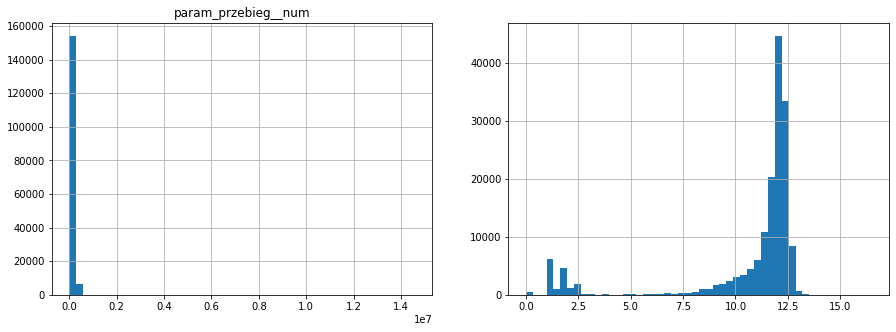

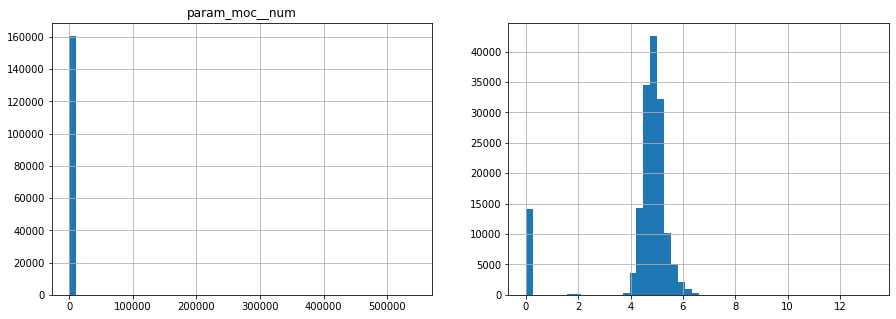

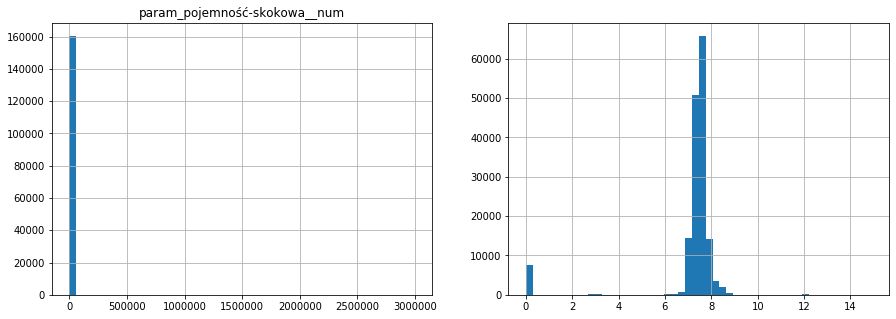

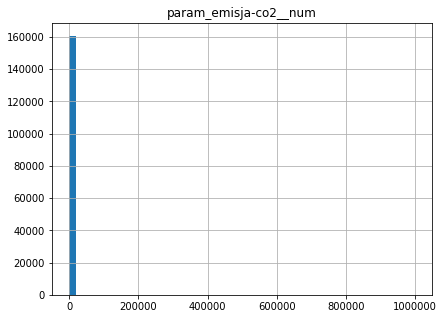

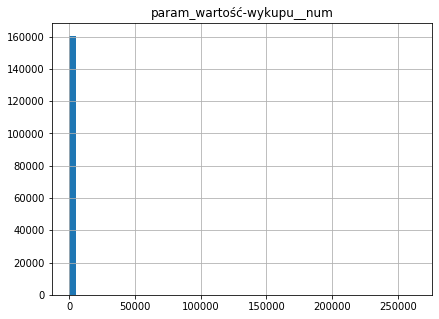

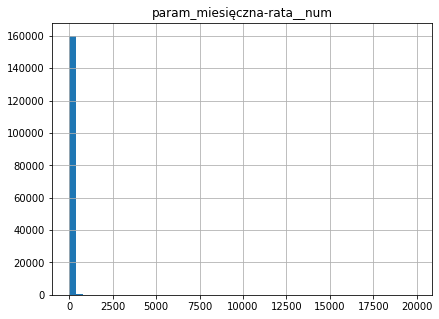

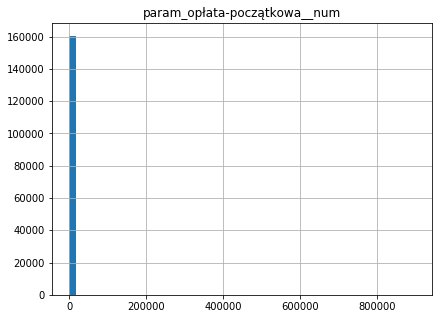

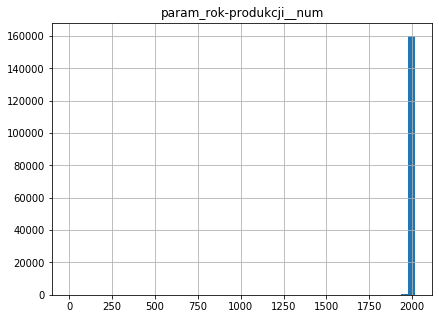

In [30]:
feats_to_log = ['param_przebieg__num', 'param_moc__num', 'param_pojemność-skokowa__num']

for feat in num_feats:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    df[feat].hist(bins=50)
    plt.title(feat)
    if feat in feats_to_log:
        plt.subplot(1,2,2)
        np.log1p(df[feat] + 1).hist(bins=50)    
    plt.show()

Features with 'long tale' characteristic were converted to logarithmic and added to features (while the non-logarithmic features were deducted). 

In [31]:
log_prefix = '__log'
for feat in feats_to_log:
    df[feat + log_prefix] = np.log1p(df[feat] + 1)
log_feats = [x for x in df.columns if log_prefix in x]
feats = feats + log_feats
feats = [x for x in feats if x + log_prefix not in log_feats]

In [32]:
feats

['feature_czujniki-parkowania-przednie',
 'feature_poduszka-powietrzna-chroniąca-kolana',
 'feature_kurtyny-powietrzne',
 'feature_klimatyzacja-dwustrefowa',
 'feature_światła-led',
 'feature_czujnik-zmierzchu',
 'feature_elektrycznie-ustawiane-lusterka',
 'feature_asr-(kontrola-trakcji)',
 'feature_poduszka-powietrzna-kierowcy',
 'feature_cd',
 'feature_elektryczne-szyby-przednie',
 'feature_poduszka-powietrzna-pasażera',
 'feature_system-start-stop',
 'feature_światła-do-jazdy-dziennej',
 'feature_komputer-pokładowy',
 'feature_elektryczne-szyby-tylne',
 'feature_klimatyzacja-manualna',
 'feature_tapicerka-welurowa',
 'feature_czujnik-deszczu',
 'feature_światła-przeciwmgielne',
 'feature_ogrzewanie-postojowe',
 'feature_radio-niefabryczne',
 'feature_regulowane-zawieszenie',
 'feature_ogranicznik-prędkości',
 'feature_zmieniarka-cd',
 'feature_szyberdach',
 'feature_isofix',
 'feature_asystent-pasa-ruchu',
 'feature_alufelgi',
 'feature_bluetooth',
 'feature_nawigacja-gps',
 'featur

In [33]:
get_X_y_and_cros_val(model, feats, log=True)

(13996.567958424248, 36.88976807779972)

As you can see above this approach did not work this time. Score worsened dramaticlly.

###### feature importance check

After each iteration of feature engineering feature importance was checked to look for features worth working on in the next step.

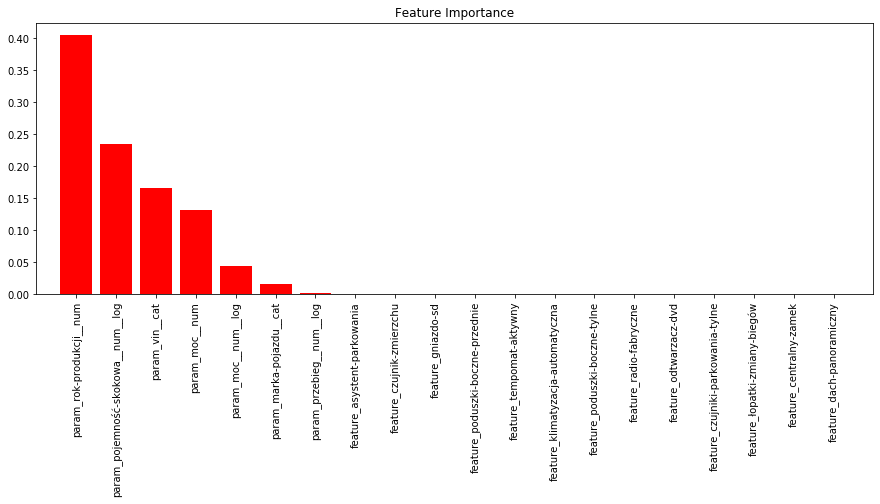

In [34]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats) + list(log_feats)

X = df[ feats ]
y = df['price_value_PLN']
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))

To double check also Permutation Importance was verified since it is calculated differently then Feature Importance. Big differences between the two would be need to be further investigated.

In [35]:
imp = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.5313 ± 0.0092,param_rok-produkcji__num
0.1855 ± 0.0069,param_pojemność-skokowa__num__log
0.1599 ± 0.0041,param_vin__cat
0.1254 ± 0.0019,param_moc__num
0.0392 ± 0.0009,param_moc__num__log
0.0089 ± 0.0005,param_marka-pojazdu__cat
0.0018 ± 0.0005,param_przebieg__num__log
0 ± 0.0000,feature_dach-panoramiczny
0 ± 0.0000,feature_centralny-zamek
0 ± 0.0000,feature_łopatki-zmiany-biegów


During error analysis in the end it came out that biggest error is generated by luxury car brands so an additional boolean feature 'luxury_car' was created.

In [36]:
luxury_car_brands = ['McLaren', 'Ferrari', 'Aston Martin', 'Lamborghini', 'Bentley', 'Rolls-Royce', 'Morgan']
df['luxury_car'] = df['param_marka-pojazdu'].map(lambda x: True if x in luxury_car_brands else False)
bool_feats = list(bool_feats)
if 'luxury_car' not in bool_feats: bool_feats.append('luxury_car')

# Preparing test train set

After feature engineering sets were divided back into train and tes.

In [37]:
df[ df['price_value_PLN'] == -1 ].shape

(54122, 213)

In [38]:
train = df[ df['price_value_PLN'] != -1]
test = df[ df['price_value_PLN'] == -1 ]

del df

In [39]:
print(train.shape)
print(test.shape)

(106494, 213)
(54122, 213)


# Model selection and optimization

Using logarithm of target variable did not bring results. All models will be tested on the same set of features using standard 3 fold cross_val_score function.

In [40]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats) + list(log_feats)
feats_log = feats
feats_log = [x for x in feats_log if x + log_prefix not in feats_log]

def get_X_y(feats):
    return train[ feats ].values, train['price_value_PLN'].values

# def test_model(model, feats):
#     X, y = get_X_y(feats)
    
#     scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
#     return np.abs(np.mean(scores)), np.std(scores)

def plot_fi_lc_e5(model, feats, pi=True, lc=True, e5=False):
    X, y = get_X_y(feats)
    model.fit(X, y)
    
    if pi:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    if lc:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');
    if e5:
        imp = PermutationImportance(model, random_state=0).fit(X,y)
        return eli5.show_weights(imp, feature_names=feats)

def get_model_importance(model, feats):
    X, y = get_X_y(feats)
    model.fit(X, y)
    importances = model.feature_importances_
    m_imp = [(feats[idx], importances[idx]) for idx in range(len(feats))]
    return sorted(m_imp, key=lambda x: x[1], reverse=True)

Firstly scores and feature importances were checked for few different models.

In [68]:
# Testing Random Forest
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
get_X_y_and_cros_val(model, feats, log=True)

44923.156269541796 47532.12649670403
35498 35498
45611.09266503413 48042.73577243788
35498 35498
45223.652602006194 47667.47768578511
35498 35498


([9294.695736753232, 9328.849739584773, 9260.204894000914], 28.02425332222485)

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

In [45]:
# testing XGB regressor
xgb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'seed': 0
}

model = XGBRegressor(**xgb_params)
get_X_y_and_cros_val(train, model, feats, log=True)

(7899.37155491214, 52.44299252352779)

In [46]:
get_X_y_and_cros_val(train, model, feats_log, log=True)

(7903.896196847567, 59.02367284760159)

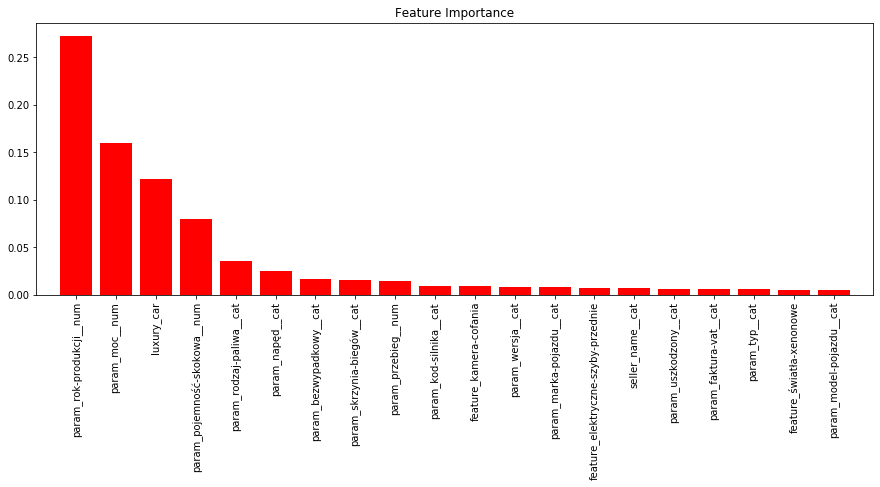

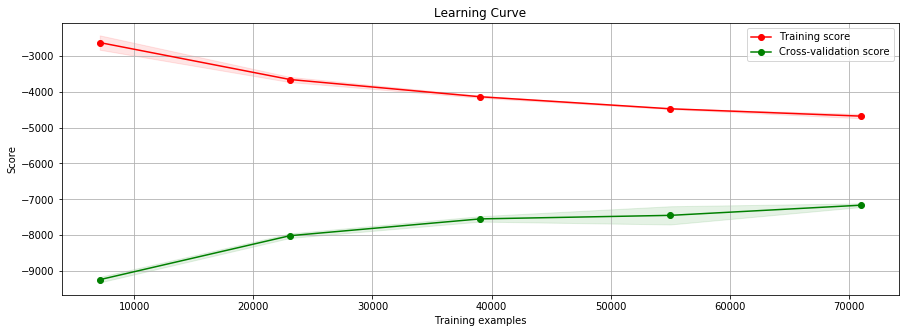

In [47]:
plot_fi_lc_e5(model, feats, True, True, False)

Additionally the hyperparameter of the XGB regressor were optimized using fmin function.

In [51]:
# Since XBG looks most promising it gets hyper optimized

def objective(space):

    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 100,
        'seed':0
    }

    print('training wiht params: {}'.format(xgb_params))
    model = XGBRegressor(**xgb_params)
    score = get_X_y_and_cros_val(train, model, feats, log=True)[0]
    
    print('score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)

training wiht params: {'max_depth': 16, 'learning_rate': 0.12138050998918799, 'colsample_bytree': 0.8386099572562234, 'subsample': 0.7077509108420624, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
score: 6548.890921824372                              

training wiht params: {'max_depth': 12, 'learning_rate': 0.06129504271630916, 'colsample_bytree': 0.802887204607142, 'subsample': 0.9549304210655494, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
score: 6866.612227080978                                                          

training wiht params: {'max_depth': 14, 'learning_rate': 0.12238800070626156, 'colsample_bytree': 0.979665901095937, 'subsample': 0.7050885162714943, 'min_child_weight': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
score: 6570.267295397071                                                         

training wiht params: {'max_depth': 8, 'learning_rate': 0.2719

score: 7292.303273718261                                                        

training wiht params: {'max_depth': 12, 'learning_rate': 0.14393422215737017, 'colsample_bytree': 0.954418869425105, 'subsample': 0.9964769737767416, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
score: 6437.593238469704                                                        

training wiht params: {'max_depth': 8, 'learning_rate': 0.1428379747975451, 'colsample_bytree': 0.9558640521775378, 'subsample': 0.9928670842089042, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
score: 6862.221104558222                                                        

training wiht params: {'max_depth': 11, 'learning_rate': 0.18861622632023906, 'colsample_bytree': 0.9799181441673053, 'subsample': 0.9635030341895483, 'min_child_weight': 6, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
score: 6580.239163004741                

After hyperoptimization new hyperparameters were checked:

In [52]:
xgb_params_opt = {'colsample_bytree': 0.9284264456653094,
                  'learning_rate': 0.09942044585563606,
                  'max_depth': 15,
                  'min_child_weight': 4,
                  'subsample': 0.9658917451320473,
                  'n_estimators': 100, 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params_opt)

In [55]:
get_X_y_and_cros_val(train, model, feats, log=True)

(6419.632921590928, 97.9502370829599)

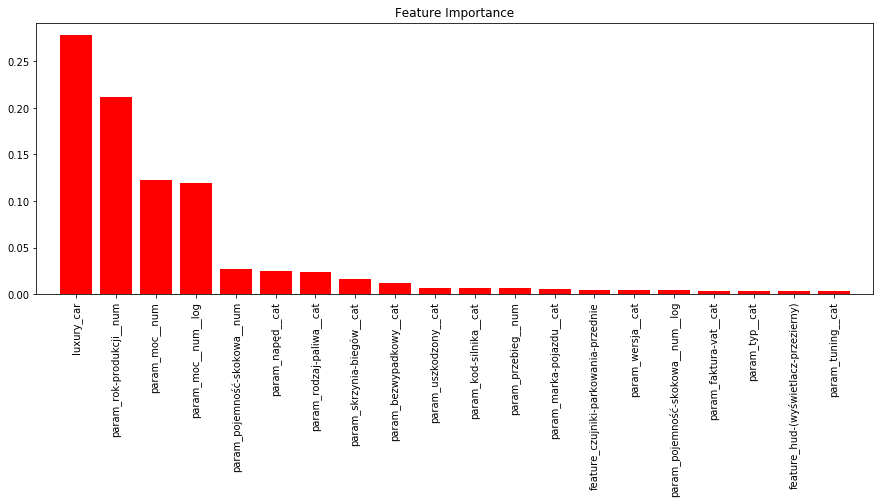

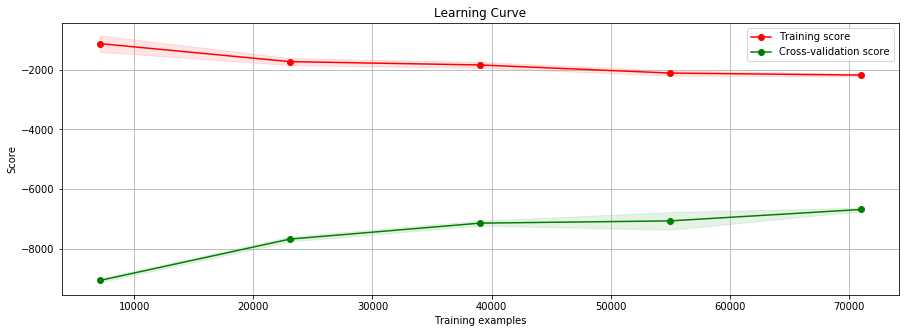

In [54]:
plot_fi_lc_e5(model, feats, True, True, False)

Model seems to be a bit over fitted so parameters were changed to:

In [ ]:
xgb_params = {'colsample_bytree': 0.8,
                  'learning_rate': 0.1,
                  'max_depth': 10,
                  'min_child_weight': 1,
                  'subsample': 0.8,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params)
test_model(model, feats)

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

Also model feature importance was checked to finally decide which features are relewant.

In [ ]:
get_model_importance(model, feats)

In [ ]:
less_feats = [ x[0] for x in get_model_importance(model, feats) if x[1] > 0.0040 ]
less_feats

In [ ]:
print(len(less_feats))
model = XGBRegressor(**xgb_params)
test_model(model, less_feats)

# Error analysis

During this project on various occasions model error was analysed. To do so error was calculated per record. 

In [ ]:
X, y = get_X_y(feats)

y_pred = cross_val_predict(model, X, y, cv=3)
train['pred'] = y_pred
train['error'] = train[['pred', 'price_value_PLN']].apply(lambda x: np.abs(x['pred'] - x['price_value_PLN']), axis=1)

To check where features can be improved records were grouped per feature. And displayed as a chart.

In [ ]:
train.groupby('param_marka-pojazdu').agg(count=('param_marka-pojazdu', np.size),mae=('error', np.mean)).reset_index().sort_values('mae', ascending=False)

In [ ]:
train[ train['param_marka-pojazdu'] == 'MacLaren' ].sort_values('error')

In [ ]:
cat_to_check = [x for x in cat_feats if len(train[x].unique()) > 4]
cat_to_check = [x for x in cat_to_check if x not in cat_no_plot]

max_cat_mae = 0
for cat in cat_to_check:
    cat_mae = train.groupby(cat).agg(mae=('error', np.mean))['mae'].max()
    if cat_mae > max_cat_mae:
        max_cat_mae = cat_mae

for cat_feat in cat_to_check:
    cat_name = cat_feat[:-len(cat_feat_prefix)]
    plt.figure(figsize=(20,5))
    order = train.groupby(cat_name)['error'].agg(np.mean).reset_index().sort_values('error', ascending=False)[cat_name]
    ax = sns.barplot(x=cat_name, y='error', data=train, order=train[cat_name].value_counts().index, color='#3498db');
    plt.xticks(rotation=90);
    ax.set(ylim=(0, max_cat_mae))
    plt.show()

As you can see even though the luxury car feature was added and is in top most important features the luxury car segment is still generating most error. You can also see that replacing missing error with -1 did not generate such big error that using more time consuming methods would be justified.

# Final predict and submit data preparation

In [ ]:
test.sample()

In [ ]:
model = XGBRegressor(**xgb_params)

model.fit(train[feats], train['price_value_PLN'])
test['price_value_PLN'] = model.predict(test[feats])
test['price_value'] = test[['price_value_PLN', 'price_currency']].apply(lambda x: x['price_value_PLN'] if x['price_currency'] == 'PLN' else x['price_value_PLN'] / 4.5, axis =1)

test[ ['car_id', 'price_value'] ].to_csv('../car_test_predict.csv', index=False)

# osiągnąć top 10 Mało brakuje